# Open Data University - Accidentologie à vélo

Dans le cadre de l'opportunité Open Data University offert par *Latitudes*, nous nous sommes proposés pour un projet de *data visualization* autour de la problematiques de l'accidentologie à vélo pour apporté notre pierre à l'édifice parmis les grandes restructuration de la mobilité en France.

Qui dit *data visualization* dit *data*.  
Nous avons donc trouver après recherche sur *www.data.gouv.fr* [les bases de données annuelles des accidents corporels de la circulation routière](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/), un ensemble de données qui donne notamment les accidents en vélo et en VAE (Vélo à Assistance Electrique). Cependant le dataset couvre un scope plus grand que notre sujet puisqu'il se porte sur l'intégralité des accidents de la circulation routière. Il nous faut donc tout d'abord procéder à un nettoyage de la donnée.

A partir de 2005, la notation des accidents est séparée entre 4 fichiers: Caractéristiques, Lieux, Véhicules, Usagers.  
Et C'est à partir du fichier Véhicules que nous allons donc pouvoir sélectionner les accidents impliquant seulement des vélo ou VAE.

In [448]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [449]:
# import pandas to download, read and filter .csv files
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [450]:
# the filepath to the .json file that contains all the dataset urls
url_fp: str = "data/metadata/urls.json"

# convert metadata file to dataframe which
url_df: pd.DataFrame = pd.read_json(url_fp)

v_cols = ['Num_Acc', 'catv']
c_cols = ['Num_Acc', 'jour', 'mois', 'an', 'hrmn', 'lum', 'atm', 'lat', 'long']
u_cols = ['Num_Acc', 'grav']
l_cols = ['Num_Acc', 'situ']
years = ['2017', '2018', '2019', '2020', '2021']

In [451]:
class Data:
    df : pd.DataFrame = None
    base_url : str | None = None

    def __init__(self, category:str, cols:list[str], year:int):
        self.category = category
        self.cols = cols
        self.year = year
    
    def get_base_url(self):
        valid_categories: list[str] = ['caractéristiques', 'lieux', 'véhicules', 'usagers']
        valid_years: list[int]= [2017, 2018, 2019, 2020, 2021]

        if self.year not in valid_years or self.category not in valid_categories:
            sys.exit('Invalid year or category')
        # Get year idx as year are in descendant order in metadata file
        year_idx: int = 2021 - self.year
        self.base_url = url_df.at[year_idx, self.category]

    def reformatCoords(self, old:str) -> str:
        new = str(old).replace(',', '.')
        return new

    def reformatDfCoords(self):
        self.df['lat'] = self.df['lat'].apply(self.reformatCoords)
        self.df['long'] = self.df['long'].apply(self.reformatCoords)

    def loadDataframe(self):
        print(self.year, self.category)
        self.get_base_url()
        if self.base_url == None:
            exit(0)
        if self.year == 2017 or self.year == 2018:
            self.df = pd.read_csv(self.base_url , sep=',', usecols=self.cols, on_bad_lines='skip', encoding="ISO-8859-1")
        else:
            self.df = pd.read_csv(self.base_url , sep=';', usecols=self.cols, on_bad_lines='skip')
        if (self.category == 'véhicules'):
            labels: list[str] = [1, 50, 80]
            self.df.query("catv == @labels", inplace=True)
            self.df.drop_duplicates(inplace=True)
        if (self.category == 'caractéristiques'):
            self.reformatDfCoords()

In [452]:
def merge_df_list(df_list:list[Data], on : list[str]):
    if (len(df_list) < 2):
        return
    
    result_df : pd.DataFrame = df_list[0].df
    for i in range (0, len(df_list)-1):
        result_df = pd.merge(result_df, df_list[i+1].df, on=on)
    return result_df

In [453]:
def get_df_years(v_cols: list[str], c_cols: list[str], u_cols: list[str], l_cols: list[str], years : list[int]) -> tuple[list[Data], pd.DataFrame]:
    valid_years: list[int]= [2017, 2018, 2019, 2020, 2021]
    for year in years:
        if year not in valid_years:
            sys.exit('Invalid year')
    result_df : pd.DataFrame = pd.DataFrame(columns=['Num_Acc', 'catv', 'jour', 'mois', 'an', 'hrmn', 'lum', 'atm', 'lat', 'long', 'grav', 'situ'])
    for year in years:
        data_list : list[Data] = []
        data_list.append(Data('véhicules', v_cols, year))
        data_list.append(Data('caractéristiques', c_cols, year))
        data_list.append(Data('usagers', u_cols, year))
        data_list.append(Data('lieux', l_cols, year))
        for data in data_list:
            data.loadDataframe()
        result_df = pd.concat([result_df, merge_df_list(data_list, ['Num_Acc'])])
    return result_df

In [454]:
def reformat_hour_min(old:str) -> str:
    new : str = ''
    if (':' in old):
        return old
    else:
        if (len(str(old)) == 3):
            new = old[:1] + ':' + old[1:]
        elif (len(str(old)) == 4):
            new = old[:2] + ':' + old[2:]
    return new

def reformat_df_hour_min(df:pd.DataFrame):
    df['hrmn'] = df['hrmn'].apply(reformat_hour_min)

def reformat_year(old : int):
    if (old > 2000):
        return old
    else:
        return old + 2000

def reformat_df_year(df:pd.DataFrame):
    df['an'] = df['an'].apply(reformat_year)


In [455]:
# result_df = get_df_years(v_cols, c_cols, u_cols, l_cols, [2017, 2018, 2019, 2020, 2021])
# result_df.drop_duplicates(inplace=True)
# result_df.to_csv('bicycle_vae_electricScooter_accidents.csv', index=False)

In [456]:
df = pd.read_csv('./bicycle_vae_electricScooter_accidents3.csv', sep=',', on_bad_lines='skip')

In [457]:
def get_sum_list_year(df : pd.DataFrame):
    return [(df.loc[df['an'] == 2017]).shape[0],
            (df.loc[df['an'] == 2018]).shape[0],
            (df.loc[df['an'] == 2019]).shape[0],
            (df.loc[df['an'] == 2020]).shape[0],
            (df.loc[df['an'] == 2021]).shape[0]]

In [458]:
def get_graph_accidents_catv():
    df_velo = df.loc[df['catv'] == 1]
    df_vae = df.loc[df['catv'] == 50]
    df_edp = df.loc[df['catv'] == 80]
    sum_velo = get_sum_list_year(df_velo)
    sum_vae = get_sum_list_year(df_vae)
    sum_edp = get_sum_list_year(df_edp)
    fig, ax = plt.subplots()
    ax.stackplot(years, sum_velo, sum_vae, sum_edp, labels=['Vélo', 'Vélo assistance électrique', 'Trottinetes élec, hoverboard, etc'], alpha=0.8)
    ax.legend(loc='upper left')
    ax.set_title('Accidents')
    ax.set_xlabel('Années')
    ax.set_ylabel('Quantité d\'accidents nécessitant urgences')
    plt.show()
    plt.savefig('accidents_vélo_vae_edpm_années.png')

In [459]:
def get_graph_deces_infra():
    df_deces = df.loc[df['grav'] == 2]
    sum_deces = get_sum_list_year(df_deces)
    df_deces_chausse = df_deces.loc[(df_deces['situ'] == 1)]
    sum_deces_chausse = get_sum_list_year(df_deces_chausse)
    df_deces_piste = df_deces.loc[(df_deces['situ'] == 5)]
    sum_deces_piste = get_sum_list_year(df_deces_piste)
    fig, ax = plt.subplots()
    ax.plot(years, sum_deces_chausse, sum_deces_piste)
    ax.set(xlabel='Années', ylabel='Décès',
        title='Décès à vélo/VAE/EDPM en fonction des années')
    plt.legend(['Chaussée', 'Piste cyclable'])
    plt.show()
    fig.savefig("deces_infra_années.png")

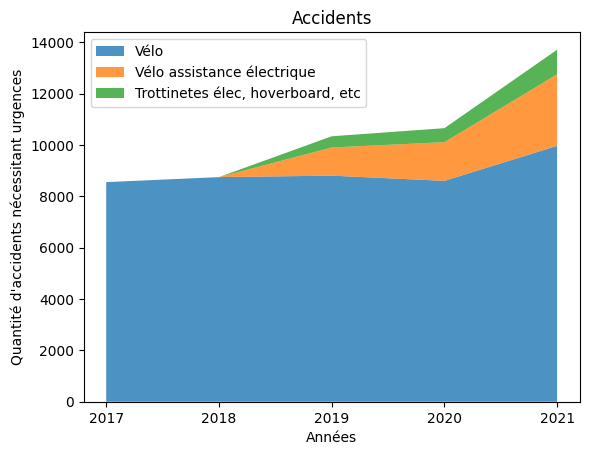

<Figure size 640x480 with 0 Axes>

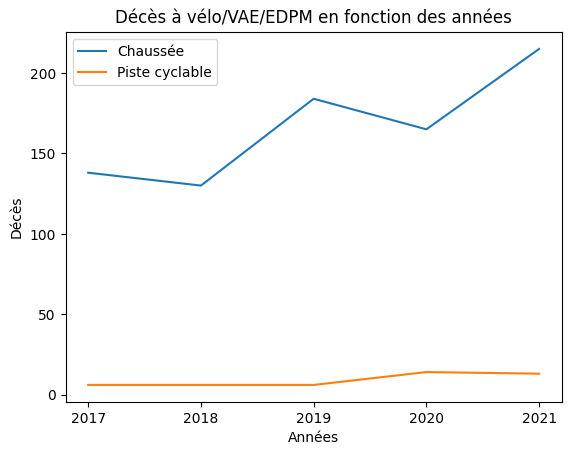

In [462]:
get_graph_accidents_catv()
get_graph_deces_infra()